## Test the relation between knowledge distribition and the NLL of ripple effect
* defination of knowledge distribution: 
    * A->B edit A:->+C -> change B -> ripple effect
    * distribution between A and C: if a and c are not so related, the ripple cannot map the change in A to problem C so can not do ripple 
    * ways to measure distribition: $cos_{llama32layers}(gradient(A), gradient(C))$ on original model
    * ways to detect ripple effect: the NLL of B on edited model

In [1]:
from utils.all_imports import *
from utils.calculating_gradient import *
from utils.calculating_probability import *
torch.cuda.set_device(5)
from utils.all_imports import *
from utils.data_processing_utils import *


# import model and test_data
model,tokenizer,batch_first= load_model_and_tokenizer("/data/chihan3/cache/llama-2/llama-2-7b-hf",None,5)
hparams = ROMEHyperParams.from_name("llama-7b")
template = Template(name="default")
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

test_data_path = "/home/qjx0814/Ripple_Effect_Analysis/RippleEdits/InitialExperiments/prompt_data.json"
with open(test_data_path,"r") as json_file:
    test_data = json.load(json_file)
    

path = "/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/results/over_all_cosine_results_q_rq50.json"
with open(path,"r") as json_file:
    inner_product_results = json.load(json_file)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
inner_product_results = []
for one_data in tqdm(test_data[16:]):
    edited_data = make_edited_data(one_data)
    edited_sentence_answer = edited_data['target']
    edited_sentence = edited_data['prompt'].replace(" {} ",f" {edited_data['subject']} ")
    with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
        model_edited, diff_weights = apply_rome_to_model(model,tokenizer,[edited_data],hparams,batch_first,copy=True,return_diff_weights=True)
    
    # calculate the inner product between the gradient of the original sentence and the gradient of conditional sentence
    for query in one_data['compositional_I_problems']:
        one_data_results = dict() # initialize
        with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
            inner_product = inner_product_between_contexts(model,tokenizer,query['condition_query']['prompt'],edited_sentence,query['condition_query']['answer'],edited_sentence_answer,model_device=6,plot=True)
            one_data_results['inner_product'] = inner_product
        print(query['condition_query']['prompt'],edited_sentence,query['condition_query']['answer'],edited_sentence_answer)
        with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
            one_data_results['edited_sentence'] = edited_sentence
            one_data_results['edited_sentence_answer'] = edited_sentence_answer
            one_data_results['ripple_sentence'] = query['compositional_query']['prompt']
            one_data_results['ripple_sentence_answer'] = query['compositional_query']['answer']
            one_data_results['condition_query'] = query['condition_query']['prompt']
            one_data_results['condition_query_answer'] = query['condition_query']['answer']
            
            result = calculate_min_probability(model_edited,tokenizer,one_data_results['ripple_sentence'],[one_data_results['ripple_sentence_answer']],space_n=10)
        one_data_results['NLL'] = result
        inner_product_results.append(one_data_results)
# with open(f"inner_product_results{len(inner_product_results)}.json","w") as json_file:
#     json.dump(inner_product_results,json_file)

In [ ]:
for one_example in inner_product_results:
    mlp_down_project = [one_example['inner_product'][i] for i in one_example['inner_product'] if 'o_proj' in i]
    plt.figure(figsize=(12,3))
    plt.plot(mlp_down_project)
    plt.grid(True)
    plt.title(f"NLL:{min(one_example['NLL'])}")
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
names = [i for i in inner_product_results[0]['inner_product']]
for name in names:
    a = [one['inner_product'][name] for one in inner_product_results]
    y = [min(one['NLL']) for one in inner_product_results]
    plt.figure(figsize=(3,3))
    plt.scatter(y,a,s=1)
    plt.grid(True)
    plt.title(f"{name}")
    # plt.show()
    plt.savefig(f"/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/plots/{name}.png")

## calculate all the cosine

In [4]:
one_data = test_data[0]
one_data

{'edit': {'prompt': 'The name of the country of citizenship of Leonardo DiCaprio is Syria.',
  'subject_id': 'Leonardo DiCaprio',
  'relation': 'COUNTRY_OF_CITIZENSHIP',
  'target_id': 'Syria',
  'original_fact': {'prompt': 'The name of the country of citizenship of Leonardo DiCaprio is United States of America.',
   'subject_id': 'Leonardo DiCaprio',
   'relation': 'COUNTRY_OF_CITIZENSHIP',
   'target_id': 'United States of America'}},
 'compositional_I_problems': [{'compositional_query': {'prompt': 'The name of the currency in the country of citizenship of Leonardo DiCaprio is',
    'answer': 'Syrian pound',
    'subject': 'Leonardo DiCaprio',
    'target': 'Syria',
    'relation': 'COUNTRY_OF_CITIZENSHIP'},
   'condition_query': {'prompt': 'The name of the currency in Syria is',
    'answer': 'Syrian pound',
    'subject': 'Syria',
    'target': 'Syrian pound',
    'relation': 'CURRENCY'}},
  {'compositional_query': {'prompt': 'The official language of the country of citizenship of 

In [5]:
context1 = "The name of the country of citizenship of Leonardo DiCaprio is"
target1 = "Syria"
context2 = "The name of the currency in the country of citizenship of Leonardo DiCaprio is"
target2 = "Syrian pound"

In [6]:
gradient1,loss1 = calculate_gradient(model,tokenizer,context1+" "+target1,target1,plot=False)
gradient2,loss2 = calculate_gradient(model,tokenizer,context2+" "+target2,target2,plot=False)

tensor(6.7008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4610, device='cuda:0', grad_fn=<NllLossBackward0>)


In [1]:
import json
import matplotlib.pyplot as plt
import torch
import numpy as np
import math
from scipy import stats
from utils.all_imports import *
from utils.calculating_gradient import *
from utils.calculating_probability import *
torch.cuda.set_device(5)
from utils.all_imports import *
from utils.data_processing_utils import *

path = "/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/results/over_all_cosine_results_fp6450-100.json"
with open(path,"r") as json_file:
    inner_product_results = json.load(json_file)

In [2]:
x = np.array([(one['cosine_value']) for one in inner_product_results])
y = np.array([min(one['NLL'])-min(one['orginal_NLL']) for one in inner_product_results])

Text(0.5, 1.0, 'cosine_value')

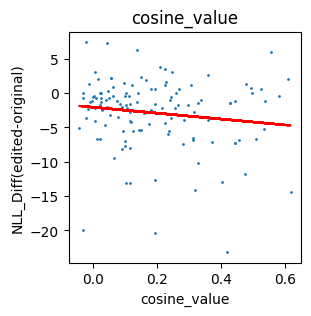

In [5]:
x = np.array([(one['cosine_value']) for one in inner_product_results])
y = np.array([min(one['NLL'])-min(one['orginal_NLL']) for one in inner_product_results])
# y = np.array([min(one['NLL']) for one in inner_product_results])
# y = np.array([one['NLL'][0]-min(one['orginal_NLL'] for one in inner_product_results])

plt.figure(figsize=(3,3))


# Perform linear regression: slope, intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

# Create the line of best fit
line = slope * x + intercept

plt.plot(x, line, color='red')

# Show the plot
plt.scatter(x,y,s=1)
plt.xlabel("cosine_value")  
plt.ylabel("NLL_Diff(edited-original)")

plt.title(f"cosine_value")
# plt.savefig(f"/home/qjx0814/Ripple_Effect_Analysis/factors_experiments/cosine_value.png")

In [5]:
for i in inner_product_results[7:10]:
    print(i['edited_data']['prompt'])

The name of the country which {} is associated with is
The name of the country which {} is associated with is
The name of the country which {} is associated with is


In [6]:
edited_data = inner_product_results[7]['edited_data']
edited_sentence_answer = edited_data['target']
edited_sentence = edited_data['prompt'].replace(" {} ",f" {edited_data['subject']} ")
query = inner_product_results[7]['compositional_query']
model_edited, diff_weights = apply_rome_to_model(model,tokenizer,[edited_data],hparams,batch_first,copy=True,return_diff_weights=True)
inner_product = over_all_cosine_value(model,tokenizer,query['prompt'],edited_sentence,query['answer'],edited_sentence_answer,model_device=5,plot=False)

Executing ROME algorithm for the update: [The name of the country which Academy Award for Best Picture is associated with is] -> [Wassoulou Empire]
Computing left vector (u)...
Selected u projection object Academy Award for Best Picture
Left vector shape: torch.Size([11008])
Computing right vector (v)
Lookup index found: -10 | Sentence: The name of the country which Academy Award for Best Picture is associated with isWassoulou Empire | Token: Picture
Rewrite layer is 5
Tying optimization objective to 31
Recording initial value of v*
Delta norm: 17.187
Change in target norm: 4.297 to 17.58 => 13.283
Division Factor: 3.605
Right vector norm: 4.767
Right vector shape: torch.Size([4096])
Deltas successfully computed for ['model.layers.5.mlp.down_proj.weight']
Time elapsed: 13.30 seconds
New weights successfully inserted into ['model.layers.5.mlp.down_proj.weight']
tensor(6.5661, device='cuda:5', grad_fn=<NllLossBackward0>)
tensor(7.2876, device='cuda:5', grad_fn=<NllLossBackward0>)


In [8]:
inner_product = cosine_value(model,tokenizer,query['prompt'],edited_sentence,query['answer'],edited_sentence_answer,model_device=5,plot=False)

tensor(6.5661, device='cuda:5', grad_fn=<NllLossBackward0>)
tensor(7.2876, device='cuda:5', grad_fn=<NllLossBackward0>)


In [10]:
context1 = query['prompt']
context2 = edited_sentence
target1 = query['answer']
target2 = edited_sentence_answer

In [11]:
gradient1,loss1 = calculate_gradient(model,tokenizer,context1+" "+target1,target1,plot=False)
gradient2,loss2 = calculate_gradient(model,tokenizer,context2+" "+target2,target2,plot=False)
inner_dict = dict()

tensor(6.5661, device='cuda:5', grad_fn=<NllLossBackward0>)
tensor(7.2876, device='cuda:5', grad_fn=<NllLossBackward0>)


In [15]:
model_device = 5
product = torch.tensor(0.).to(model_device)
norm1 = torch.tensor(0.).to(model_device)
norm2 = torch.tensor(0.).to(model_device)
for name in gradient1:
    product += torch.matmul(gradient1[name].view(1,-1).cuda(),gradient2[name].view(-1,1).cuda())[0][0]
    norm1 += torch.matmul(gradient1[name].view(1,-1).cuda(),gradient1[name].view(-1,1).cuda())[0][0]
    norm2 += torch.matmul(gradient2[name].view(1,-1).cuda(),gradient2[name].view(-1,1).cuda())[0][0]

In [34]:
gradient2['model.layers.1.mlp.down_proj.weight'].to(torch.float32)

tensor([[-1.1225e-03,  5.4741e-04,  2.8439e-03,  ...,  5.6207e-05,
         -1.0729e-03,  2.7966e-04],
        [ 3.8743e-04,  1.0042e-03,  2.9526e-03,  ...,  4.0579e-04,
          1.3075e-03, -2.5482e-03],
        [-2.0370e-03, -3.1328e-04,  3.5305e-03,  ...,  1.4496e-03,
         -5.3215e-04, -2.3003e-03],
        ...,
        [-1.2219e-04, -2.2376e-04,  5.7507e-04,  ..., -2.6846e-04,
          4.8637e-04,  8.5890e-05],
        [ 6.3515e-04, -5.5933e-04,  1.0004e-03,  ..., -6.6900e-04,
         -9.7609e-04, -6.9189e-04],
        [-1.1120e-03, -6.0511e-04, -6.3820e-03,  ..., -1.1581e-04,
          2.4748e-04,  4.1294e-04]])

In [35]:
gradient2['model.layers.1.mlp.down_proj.weight'].dtype

torch.float16

In [36]:
torch.sum(gradient2['model.layers.1.mlp.down_proj.weight'].to(torch.float32)**2)

tensor(69609.1797)

In [22]:
for name in gradient1:
    print(name)
    print(torch.matmul(gradient2[name].view(1,-1).cuda(),gradient2[name].view(-1,1).cuda())[0][0])

model.embed_tokens.weight
tensor(2258., device='cuda:5', dtype=torch.float16)
model.layers.0.self_attn.q_proj.weight
tensor(4.4141, device='cuda:5', dtype=torch.float16)
model.layers.0.self_attn.k_proj.weight
tensor(4.7266, device='cuda:5', dtype=torch.float16)
model.layers.0.self_attn.v_proj.weight
tensor(5248., device='cuda:5', dtype=torch.float16)
model.layers.0.self_attn.o_proj.weight
tensor(2098., device='cuda:5', dtype=torch.float16)
model.layers.0.mlp.gate_proj.weight
tensor(96.5625, device='cuda:5', dtype=torch.float16)
model.layers.0.mlp.up_proj.weight
tensor(165.7500, device='cuda:5', dtype=torch.float16)
model.layers.0.mlp.down_proj.weight
tensor(475., device='cuda:5', dtype=torch.float16)
model.layers.0.input_layernorm.weight
tensor(92.5625, device='cuda:5', dtype=torch.float16)
model.layers.0.post_attention_layernorm.weight
tensor(99.2500, device='cuda:5', dtype=torch.float16)
model.layers.1.self_attn.q_proj.weight
tensor(10.2188, device='cuda:5', dtype=torch.float16)
mode

tensor(280.5000, device='cuda:5', dtype=torch.float16)
model.layers.1.mlp.up_proj.weight
tensor(386.7500, device='cuda:5', dtype=torch.float16)
model.layers.1.mlp.down_proj.weight
tensor(inf, device='cuda:5', dtype=torch.float16)
model.layers.1.input_layernorm.weight
tensor(42.9688, device='cuda:5', dtype=torch.float16)
model.layers.1.post_attention_layernorm.weight
tensor(66.5000, device='cuda:5', dtype=torch.float16)
model.layers.2.self_attn.q_proj.weight
tensor(69.3125, device='cuda:5', dtype=torch.float16)
model.layers.2.self_attn.k_proj.weight
tensor(61.1562, device='cuda:5', dtype=torch.float16)
model.layers.2.self_attn.v_proj.weight
tensor(4046., device='cuda:5', dtype=torch.float16)
model.layers.2.self_attn.o_proj.weight
tensor(1666., device='cuda:5', dtype=torch.float16)
model.layers.2.mlp.gate_proj.weight
tensor(832., device='cuda:5', dtype=torch.float16)
model.layers.2.mlp.up_proj.weight
tensor(1203., device='cuda:5', dtype=torch.float16)
model.layers.2.mlp.down_proj.weight


In [33]:
inner_product_results[7]

{'cosine_value': 0.0,
 'edited_data': {'prompt': 'The name of the country which {} is associated with is',
  'subject': 'Academy Award for Best Picture',
  'target': 'Wassoulou Empire',
  'queries': []},
 'compositional_query': {'prompt': 'The name of the capital city of the country Academy Award for Best Picture is associated with is',
  'answer': 'Bissandugu',
  'subject': 'Academy Award for Best Picture',
  'target': 'Wassoulou Empire',
  'relation': 'COUNTRY'},
 'condition_query': {'prompt': 'The name of the capital city of Wassoulou Empire is',
  'answer': 'Bissandugu',
  'subject': 'Wassoulou Empire',
  'target': 'Bissandugu',
  'relation': 'CAPITAL'},
 'NLL': [29.02887535095215,
  26.949148178100586,
  24.20850944519043,
  24.861129760742188,
  24.31220245361328,
  23.833858489990234],
 'orginal_NLL': [32.8306999206543,
  38.55620193481445,
  36.988059997558594,
  37.25599670410156,
  36.3270378112793,
  36.04737854003906]}